In [1]:
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../src/')
import geometry
import solver


In [2]:
tube = geometry.obstructed_tube(N=4096)
a, da, t, dt_da, k = tube.get_data()

x = t.real
y = t.imag
u = 1 - y**2
v = np.zeros(len(a))
u[np.abs(t.real) <= 1] = 0

solver = solver.stokes2d(tube, u, v)

gmres starts solving the Nystorm, please wait...
gmres converged


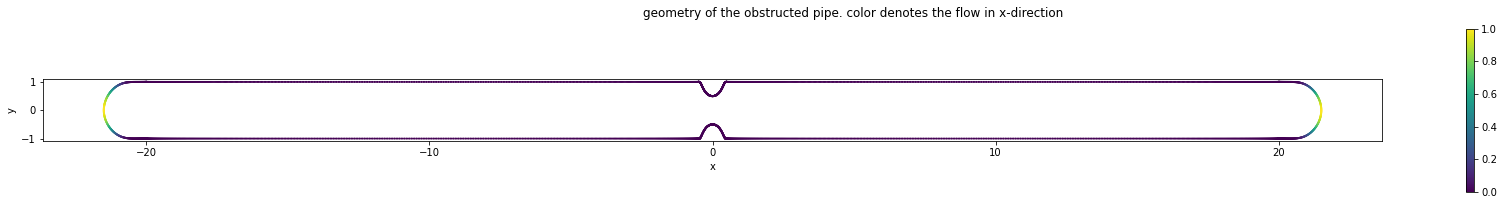

In [4]:
fig, ax = plt.subplots(figsize=(30,3))
ax.scatter(t.real, t.imag, c=u,s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
im = ax.set_aspect(1)
fig.suptitle('geometry of the obstructed pipe. color denotes the flow in x-direction')
fig.colorbar(im)

# return to poiseuille

In [5]:
grid = np.array([(x,y) for x in np.linspace(0,20,100) for y in np.linspace(0,0.9,10)])
grid_x, grid_y = grid.T
grid_z = grid_x + 1j*grid_y

grid_v = solver.compute_velocity(grid_z)
grid_grad_p = solver.compute_grad_pressure(grid_z)
poi_v = 1 - grid_z.imag ** 2
poi_grad_p = -2*np.ones(poi_v.shape)

In [6]:
grid_z = grid_z.reshape((100,10)).T
grid_v = grid_v.reshape((100,10)).T
grid_grad_p = grid_grad_p.reshape((100,10)).T
poi_v = poi_v.reshape((100,10)).T
poi_grad_p = poi_grad_p.reshape((100,10)).T

Text(0.5, 1.0, 'abs velocity diff between the poiseuille flow and the computed flow\nR=1, L=40, N=4096, Obstruction Height=0.5')

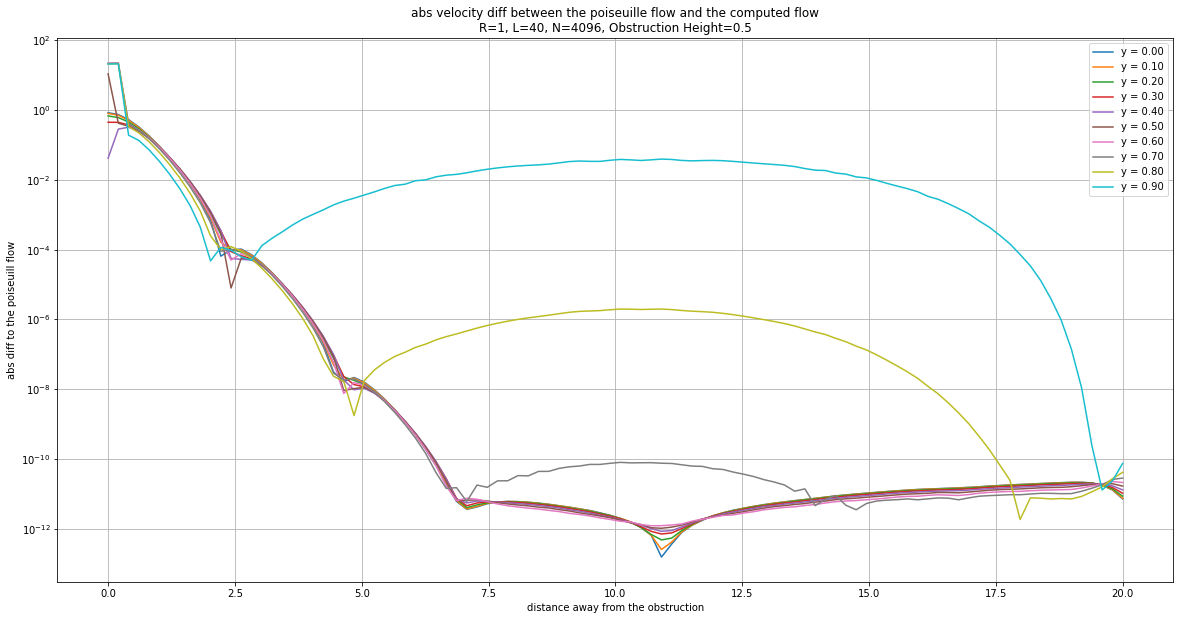

In [11]:
plt.figure(figsize=(20,10))
for i in range(10):
    z = grid_z[i]
    val = grid_v[i]
    poi = poi_v[i]
    abs_diff = np.abs(val - poi)
    y = z[0].imag
    x = z.real
    plt.semilogy(x,abs_diff,label='y = %.2f'%y)
plt.xlabel('distance away from the obstruction')
plt.ylabel('abs diff to the poiseuill flow')
plt.legend()
plt.grid('both')
plt.title('abs velocity diff between the poiseuille flow and the computed flow\n' + 'R=%d,'%1 + ' L=%d,'%40 + ' N=%d, '%4096 + 'Obstruction Height=%.1f'%0.5)

there are a few curves not converging to poiseuille. This is essentially because we are not using enough points on the boundary. See [experiment1 copy](./experiment1%20copy.ipynb) for a model with much more points. 

It is important to understand that the error all converge at last because we have enforced poiseuille condition on the boundary. 

Text(0.5, 1.0, 'abs grad_p diff between the poiseuille flow and the computed flow\nR=1, L=40, N=4096, Obstruction Height=0.5')

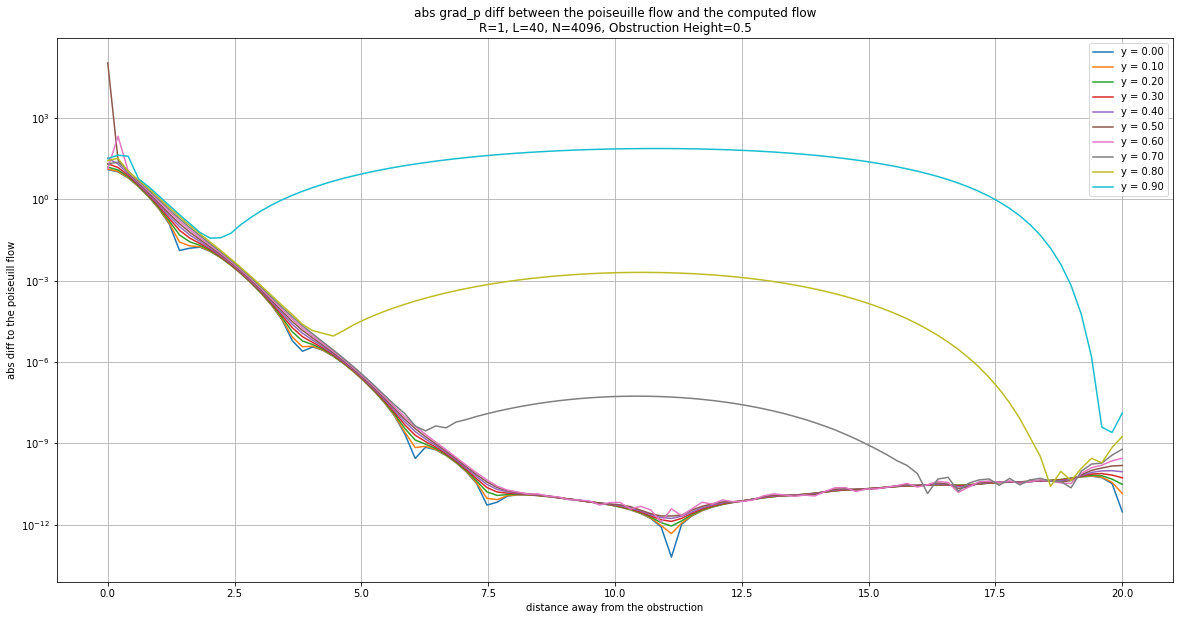

In [12]:
plt.figure(figsize=(20,10))
for i in range(10):
    z = grid_z[i]
    val = grid_grad_p[i]
    poi = poi_grad_p[i]
    abs_diff = np.abs(val - poi)
    y = z[0].imag
    x = z.real
    plt.semilogy(x,abs_diff,label='y = %.2f'%y)
plt.xlabel('distance away from the obstruction')
plt.ylabel('abs diff to the poiseuill flow')
plt.legend()
plt.grid('both')
plt.title('abs grad_p diff between the poiseuille flow and the computed flow\n' + 'R=%d,'%1 + ' L=%d,'%40 + ' N=%d, '%4096 + 'Obstruction Height=%.1f'%0.5)